In [ ]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets
!pip install -q torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets
import cv2
from pytorch_lightning.callbacks import EarlyStopping


In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:

resolution = 128
num_classes = 3

batch_size = 4
num_workers = 2
num_epochs = 16
learning_rate = 0.00075
weight_decay = 1e-4
width = 256

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, images_folder, labels_file, img_size=(128, 128), transform=None):
        self.images_folder = images_folder
        self.labels = pd.read_excel(labels_file)
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_name = self.labels.iloc[idx]['name']
        image_path = os.path.join(self.images_folder, image_name)

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            label = self.labels.iloc[idx]['label']
            return image, label
        except Exception as e:
            print(f"hiba a kép betöltésekor: {image_path}, hiba: {e}")
            return None

class ToEdgeDetection:
    def __call__(self, image):
        # Convert to grayscale
        grayscale_image = transforms.functional.rgb_to_grayscale(image, num_output_channels=1)
        # Convert to NumPy array
        image_np = np.array(grayscale_image)
        # Ensure the array has the correct shape
        if len(image_np.shape) == 3:
            image_np = image_np[:, :, 0]  # Take the first channel if there are multiple
        # Apply edge detection
        edges = cv2.Canny(image_np, threshold1=60, threshold2=150)
        # Convert to tensor and normalize
        edge_tensor = torch.tensor(edges / 255.0, dtype=torch.float32).unsqueeze(0)
        # Duplicate the single channel to make it compatible with other augmentations
        edge_tensor = edge_tensor.repeat(3, 1, 1)
        return edge_tensor


def create_data_loaders(images_folder, labels_file, img_size=(512, 512), batch_size=32):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomResizedCrop(size=img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        ToEdgeDetection(),  # Custom edge detection
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    # Load the dataset
    dataset = ChessDataset(images_folder, labels_file, img_size, transform)

    # Adjust labels to zero-based indices
    label_mapping = {0: 0, 1: 1, 2: 2}
    dataset.labels['label'] = dataset.labels['label'].map(label_mapping)

    # Split into train, val, and test
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
images_folder = '/content/drive/MyDrive/Melytanulas Nagyprojekt/images'
labels_file = '/content/drive/MyDrive/Melytanulas Nagyprojekt/labels.xlsx'
train_loader, val_loader, test_loader = create_data_loaders(images_folder, labels_file)

In [ ]:
import pytorch_lightning as pl

class ChessDataModule(pl.LightningDataModule):
    def __init__(self, images_folder, labels_file, img_size=(512, 512), batch_size=32):
        super().__init__()
        self.images_folder = images_folder
        self.labels_file = labels_file
        self.img_size = img_size
        self.batch_size = batch_size

    def setup(self, stage=None):
        # Initialize train, val, test loaders
        self.train_loader, self.val_loader, self.test_loader = create_data_loaders(
            self.images_folder, self.labels_file, self.img_size, self.batch_size
        )

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader


In [ ]:
datamodule = ChessDataModule(images_folder, labels_file, img_size=(512, 512), batch_size=32)

## Visualization
* PyTorch uses channels first representation (batch, channels, height, width) vs channels last (batch, height, width, channels) by default. Keep that in mind during visualization, because matplotlib expects channels last format.

In [ ]:
def visualize_images(data_loader, num_images=4, num_augmentations=5):
    # Set up the figure for displaying images
    fig = plt.figure(figsize=(10, 8))
    data_iter = iter(data_loader)

    for row in range(num_images):
        images, labels = next(data_iter)  # Get a batch of images and labels
        for column in range(num_augmentations):
            image = images[column]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.permute(1, 2, 0))  # Convert image tensor to (H, W, C) format for display
            plt.axis('off')

    plt.show()


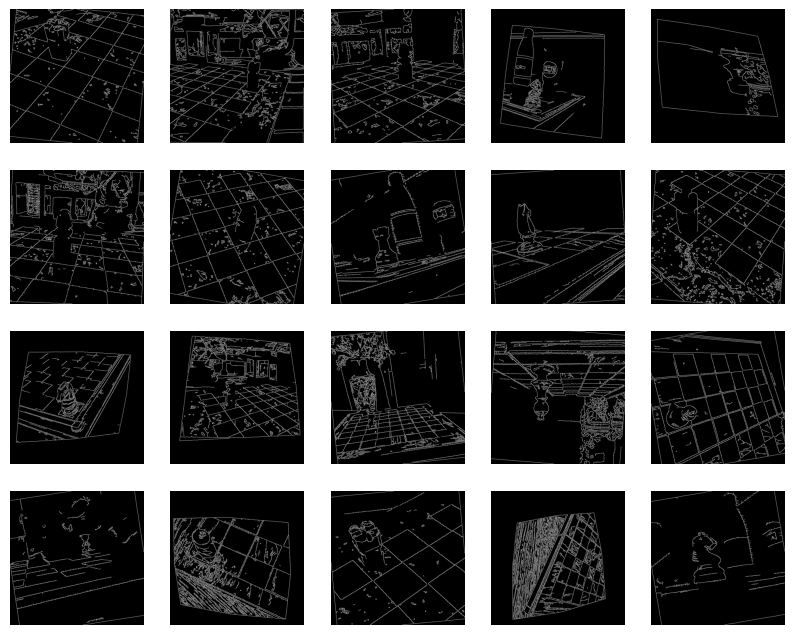

In [ ]:
visualize_images(train_loader, num_images=4, num_augmentations=5)

# Classifier Model Definition


In [ ]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        # Compute loss
        loss = F.cross_entropy(pred_labels, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        # Calculate accuracy and log it
        accuracy = self.accuracy(pred_labels, labels)
        self.log("val_accuracy", accuracy, on_step=False, on_epoch=True)  # Log as "val_accuracy"

        return loss



    def training_step(self, batch, batch_idx):
        images, labels = batch  # Unpack the tuple
        pred_labels = self(images)  # Forward pass with images
        loss = F.cross_entropy(pred_labels, labels)  # Compute the loss with labels

        # Optionally, log the loss
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        #return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        #return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)

## Convolutional Neural Network Definiton

* Observe our custom CNN.
* What do each of the Conv2d parameters mean?
* What are the output shapes of each layer?
* What is a fully convolutional neural network? What is their advantage?

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes)
)

"""
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(32),  # Matches Conv2d out_channels
    torch.nn.ReLU(),

    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(64),  # Matches Conv2d out_channels
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(128),  # Matches Conv2d out_channels
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(256),  # Matches Conv2d out_channels
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),

    torch.nn.AdaptiveAvgPool2d(output_size=(4, 4)),

    torch.nn.Flatten(),
    torch.nn.ReLU(),  # Fully connected hidden layer
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(512, num_classes)  # Output layer
    """

# model = torchvision.models.mobilenet_v2(num_classes=num_classes)

# model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): AdaptiveAvgPool2d(output_size

## Training
* We log our metrics using a `WandbLogger`.
* We save our best checkpoints using a `ModelCheckpoint` callback.

Best practices:
* Use 16-bit floating point mixed precision for >2x faster training and 2x lower GPU memory consumption.
* If using a PyTorch 2.x on a modern GPU (Volta or Ampere architecture e.g. V100 or A100), compile your neural network.
* For better GPU utilization, use larger batch sizes.

In [ ]:
#model = torch.compile(model)
lit_model = ImageClassifier(model)

wandb_logger = pl.loggers.WandbLogger(project="melytanulas_nagyprojekt", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_accuracy", mode="max")
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[early_stopping_callback, pl.callbacks.ModelCheckpoint(dirpath=".", filename=f"model", monitor="val_accuracy")],
)
trainer.fit(lit_model, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_accuracy improved. New best score: 0.273


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_accuracy improved by 0.045 >= min_delta = 0.0. New best score: 0.318


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_accuracy did not improve in the last 5 records. Best score: 0.318. Signaling Trainer to stop.


epoch,▁▁▂▂▃▃▅▅▆▆▁▁▂▂▃▃▅▅▆▆▇▇██
train_loss_epoch,█▃▁▁▁▄▁▂▂▂▂▁
trainer/global_step,▁▁▂▂▃▃▅▅▆▆▁▁▂▂▃▃▅▅▆▆▇▇██
val_accuracy,▁▁▁▁▁▅██████
val_loss,▄█▅▄▄▁▁▁▂▁▁▁
epoch,6
train_loss_epoch,1.09683
trainer/global_step,27
val_accuracy,0.31818
val_loss,1.10352


In [ ]:
checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')
print(checkpoint['state_dict'].keys())


odict_keys(['model.0.weight', 'model.0.bias', 'model.1.weight', 'model.1.bias', 'model.1.running_mean', 'model.1.running_var', 'model.1.num_batches_tracked', 'model.3.weight', 'model.3.bias', 'model.4.weight', 'model.4.bias', 'model.4.running_mean', 'model.4.running_var', 'model.4.num_batches_tracked', 'model.7.weight', 'model.7.bias', 'model.8.weight', 'model.8.bias', 'model.8.running_mean', 'model.8.running_var', 'model.8.num_batches_tracked', 'model.13.weight', 'model.13.bias'])


<ipython-input-269-36f75867f2b6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')


In [ ]:
model = ImageClassifier(model)
print(model.state_dict().keys())


odict_keys(['model.0.weight', 'model.0.bias', 'model.1.weight', 'model.1.bias', 'model.1.running_mean', 'model.1.running_var', 'model.1.num_batches_tracked', 'model.3.weight', 'model.3.bias', 'model.4.weight', 'model.4.bias', 'model.4.running_mean', 'model.4.running_var', 'model.4.num_batches_tracked', 'model.7.weight', 'model.7.bias', 'model.8.weight', 'model.8.bias', 'model.8.running_mean', 'model.8.running_var', 'model.8.num_batches_tracked', 'model.11.weight', 'model.11.bias', 'model.12.weight', 'model.12.bias', 'model.12.running_mean', 'model.12.running_var', 'model.12.num_batches_tracked', 'model.17.weight', 'model.17.bias'])


In [ ]:
model_kiertekel = ImageClassifier(model)
checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')
model_kiertekel.load_state_dict(checkpoint['state_dict'], strict=False)


<ipython-input-271-c082642ddb91>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')


_IncompatibleKeys(missing_keys=['model.model.0.weight', 'model.model.0.bias', 'model.model.1.weight', 'model.model.1.bias', 'model.model.1.running_mean', 'model.model.1.running_var', 'model.model.3.weight', 'model.model.3.bias', 'model.model.4.weight', 'model.model.4.bias', 'model.model.4.running_mean', 'model.model.4.running_var', 'model.model.7.weight', 'model.model.7.bias', 'model.model.8.weight', 'model.model.8.bias', 'model.model.8.running_mean', 'model.model.8.running_var', 'model.model.11.weight', 'model.model.11.bias', 'model.model.12.weight', 'model.model.12.bias', 'model.model.12.running_mean', 'model.model.12.running_var', 'model.model.17.weight', 'model.model.17.bias'], unexpected_keys=['model.0.weight', 'model.0.bias', 'model.1.weight', 'model.1.bias', 'model.1.running_mean', 'model.1.running_var', 'model.1.num_batches_tracked', 'model.3.weight', 'model.3.bias', 'model.4.weight', 'model.4.bias', 'model.4.running_mean', 'model.4.running_var', 'model.4.num_batches_tracked', 

In [ ]:
# Print current model keys
print("Model state dict keys:", model_kiertekel.state_dict().keys())

# Print checkpoint keys
checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')
print("Checkpoint state dict keys:", checkpoint['state_dict'].keys())


Model state dict keys: odict_keys(['model.model.0.weight', 'model.model.0.bias', 'model.model.1.weight', 'model.model.1.bias', 'model.model.1.running_mean', 'model.model.1.running_var', 'model.model.1.num_batches_tracked', 'model.model.3.weight', 'model.model.3.bias', 'model.model.4.weight', 'model.model.4.bias', 'model.model.4.running_mean', 'model.model.4.running_var', 'model.model.4.num_batches_tracked', 'model.model.7.weight', 'model.model.7.bias', 'model.model.8.weight', 'model.model.8.bias', 'model.model.8.running_mean', 'model.model.8.running_var', 'model.model.8.num_batches_tracked', 'model.model.11.weight', 'model.model.11.bias', 'model.model.12.weight', 'model.model.12.bias', 'model.model.12.running_mean', 'model.model.12.running_var', 'model.model.12.num_batches_tracked', 'model.model.17.weight', 'model.model.17.bias'])
Checkpoint state dict keys: odict_keys(['model.0.weight', 'model.0.bias', 'model.1.weight', 'model.1.bias', 'model.1.running_mean', 'model.1.running_var', 'm

<ipython-input-274-c73fe2668001>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')


In [ ]:
checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')
state_dict = checkpoint['state_dict']

# Adjust the key mapping
new_state_dict = {}
for key, value in state_dict.items():
    if "model.model.13" in key:  # Handle unexpected keys
        new_key = key.replace("model.model.13", "model.model.12")  # Example mapping
    elif "model.model.12" in key:
        new_key = key.replace("model.model.12", "model.model.11")  # Example mapping
    else:
        new_key = key
    new_state_dict[new_key] = value

# Load adjusted state dict
model_kiertekel = ImageClassifier(model)
model_kiertekel.load_state_dict(new_state_dict, strict=False)  # Use strict=True if keys fully match


<ipython-input-275-1ae66c77f570>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/best_model.ckpt', map_location='cpu')


_IncompatibleKeys(missing_keys=['model.model.0.weight', 'model.model.0.bias', 'model.model.1.weight', 'model.model.1.bias', 'model.model.1.running_mean', 'model.model.1.running_var', 'model.model.3.weight', 'model.model.3.bias', 'model.model.4.weight', 'model.model.4.bias', 'model.model.4.running_mean', 'model.model.4.running_var', 'model.model.7.weight', 'model.model.7.bias', 'model.model.8.weight', 'model.model.8.bias', 'model.model.8.running_mean', 'model.model.8.running_var', 'model.model.11.weight', 'model.model.11.bias', 'model.model.12.weight', 'model.model.12.bias', 'model.model.12.running_mean', 'model.model.12.running_var', 'model.model.17.weight', 'model.model.17.bias'], unexpected_keys=['model.0.weight', 'model.0.bias', 'model.1.weight', 'model.1.bias', 'model.1.running_mean', 'model.1.running_var', 'model.1.num_batches_tracked', 'model.3.weight', 'model.3.bias', 'model.4.weight', 'model.4.bias', 'model.4.running_mean', 'model.4.running_var', 'model.4.num_batches_tracked', 

In [ ]:
model_kiertekel = ImageClassifier(model)
model_kiertekel.load_state_dict(checkpoint['state_dict'], strict=False)


_IncompatibleKeys(missing_keys=['model.model.0.weight', 'model.model.0.bias', 'model.model.1.weight', 'model.model.1.bias', 'model.model.1.running_mean', 'model.model.1.running_var', 'model.model.3.weight', 'model.model.3.bias', 'model.model.4.weight', 'model.model.4.bias', 'model.model.4.running_mean', 'model.model.4.running_var', 'model.model.7.weight', 'model.model.7.bias', 'model.model.8.weight', 'model.model.8.bias', 'model.model.8.running_mean', 'model.model.8.running_var', 'model.model.11.weight', 'model.model.11.bias', 'model.model.12.weight', 'model.model.12.bias', 'model.model.12.running_mean', 'model.model.12.running_var', 'model.model.17.weight', 'model.model.17.bias'], unexpected_keys=['model.0.weight', 'model.0.bias', 'model.1.weight', 'model.1.bias', 'model.1.running_mean', 'model.1.running_var', 'model.1.num_batches_tracked', 'model.3.weight', 'model.3.bias', 'model.4.weight', 'model.4.bias', 'model.4.running_mean', 'model.4.running_var', 'model.4.num_batches_tracked', 

In [ ]:
model_kiertekel.eval()
# Test on a validation batch or specific sample
output = model_kiertekel(torch.randn(1, 3, resolution, resolution))
print(output)


tensor([[ 0.1255,  0.0113, -0.0419]], grad_fn=<AddmmBackward0>)
